# SIGNATE ソニーグループ合同 データ分析コンペティション NaN位 解法

本Notebookは2023年にSIGNATEで開催された[ソニーグループ合同 データ分析コンペティション](https://signate.jp/courses/OJXBVN6v3M9RYvdZ)で以下のスコアを出したときのパイプラインです。（受賞対象外者なのでLBからは消えているかもしれません）

* **Public LB**: 0.9930182
* **Private LB**: 0.9934195

解法は ①サイコロ部分の切り出しを行い、②切り出したサイコロの出目を予測するというシンプルな2段階構成です。

<img src=docs/solution.png width=800px>

パイプラインは以下の通りで、Notebookのセルを上から順番に実行することでパイプラインを順次実行します。

<img src=docs/pfd.png width=800px>

なお、再現性は完全に担保されません。これは作成するモデルの1つにサイコロの中心を求めるモデルがありますが、このモデルにtorch.nn.functional.interpolate()が含まれることに起因します。interpolateを用いたモデルはPyTorchの仕様上、再現性を担保することができません。詳細はPyTorch公式の[REPRODUCIBILITY](https://pytorch.org/docs/stable/notes/randomness.html)と[TORCH.USE_DETERMINISTIC_ALGORITHMS](https://pytorch.org/docs/stable/generated/torch.use_deterministic_algorithms.html#torch.use_deterministic_algorithms)のページをご参照ください。件のモデルはデータセットを作成する際に使用するため作成されるデータセットの再現性は担保されず、結果としてSubmitの内容に再現性はありません。参考までに2回試してLBのスコアを確認したところ1回目は0.9930182で2回目は0.9930985でした。

## Import

In [1]:
from typing import List, Union, Optional

import math
import random
from pathlib import Path
from collections import Counter
from dataclasses import dataclass

import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Config

In [2]:
@dataclass(frozen=True)
class Config:
    x_train_path: str = 'X_train.npy'
    y_train_path: str = 'y_train.npy'
    x_test_path: str = 'X_test.npy'

## Helper Functions

In [3]:
def show_images(images: Union[np.ndarray, List[np.ndarray]],
                titles: Optional[List[str]] = None,
                show_indices: Optional[List[int]] = None,
                ncols: int = 10,
                ) -> None:
    if show_indices is None:
        show_indices = list(range(len(images)))
    if titles is None:
        titles = list(map(str, show_indices))

    nrows = math.ceil(len(show_indices) / ncols)
    _, axes = plt.subplots(nrows, ncols, figsize=(1.6*ncols, 1.6*nrows), tight_layout=True)

    for i, (show_index, title) in enumerate(zip(show_indices, titles)):
        x = i % ncols
        y = i // ncols
        image = images[show_index]
        if nrows == 1:
            axes[x].imshow(image, cmap='gray')
            axes[x].set_title(title)
        else:
            axes[y][x].imshow(image, cmap='gray')
            axes[y][x].set_title(title)

In [4]:
def show_center_dataset(x_train_path: str,
                        y_train_path: str,
                        y_train_center_path: str,
                        y_train_center_target_path: str,
                        show_image_count: int = 10,
                        ) -> None:
    x_train = np.load(x_train_path)
    y_train = np.load(y_train_path)
    y_train_center = np.load(y_train_center_path)
    y_train_center_target = np.load(y_train_center_target_path)

    indices = np.arange(len(x_train))
    np.random.shuffle(indices)
    indices = indices[:show_image_count]

    images = []
    titles = []
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (255, 0, 255), (0, 255, 255),]
    for image, target, centers, center_targets in zip(x_train[indices], y_train[indices], y_train_center[indices], y_train_center_target[indices]):
        image = image.reshape(20, 20)
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        for center, center_target in zip(centers, center_targets):
            if center.tolist() != [-1.0, -1.0]:
                image = cv2.circle(image,
                                (int(round(center[0], 0)), int(round(center[1], 0))),
                                1, colors[center_target-1], thickness=-1)

        images.append(image)
        titles.append(f'{target}')
    show_images(images, titles)

## シード固定

ランダムに画像を表示する際に結果がばらつかないようシードを固定する

In [5]:
random.seed(42)
np.random.seed(42)

## X_trainの各画像に写っているサイコロの数を推定する

輝度が2以上のピクセル数の数を数えることでX_train.npyに収録された各画像に写っているサイコロの数を推定する。推定したサイコロの数はデータセット作成に使用する。

In [6]:
!python3 tools/estimate_num_dices.py {Config.x_train_path}

save data/X_train_num_dices.npy


### 可視化

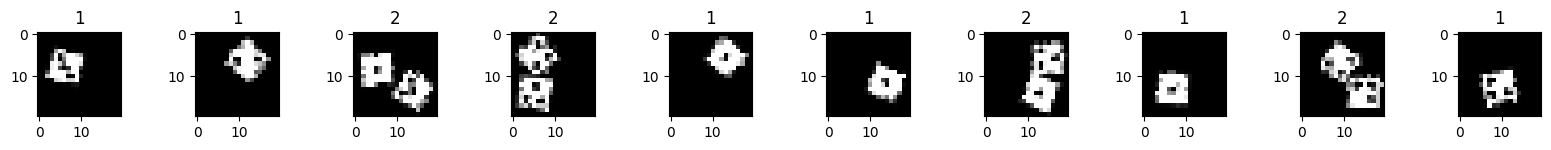

In [7]:
X_TRAIN = np.load(Config.x_train_path).reshape(-1, 20, 20)
X_TRAIN_NUM_DICES = np.load('data/X_train_num_dices.npy')
show_images(X_TRAIN[:10], titles=[str(n) for n in X_TRAIN_NUM_DICES[:10]])

## P1. キーポイントデータセット作成 (1回目)

サイコロが1つ映った画像にOpenCVの輪郭推定機能を用いてサイコロの中心位置と出目をアノテーションする。そのままだとデータセットにサイコロが1つ映った画像しか含まれないため、アノテーションしたサイコロ同士をランダムに配置して2つのサイコロが映った画像も作成する。

In [8]:
if not Path('data/center_dataset_1st').exists():
    !python3 tools/create_center_dataset.py {Config.x_train_path} \
                                            {Config.y_train_path} \
                                            data/X_train_num_dices.npy \
                                            data/center_dataset_1st \
                                            --two_dice

アノテーションを自動で作成します
100%|███████████████████████████████| 200000/200000 [00:01<00:00, 114107.88it/s]
画像同士を組み合わせてサイコロが2つ映った画像を作成中・・・（数分かかるので気長に待機してください）
save data/center_dataset_1st/X_train.npy
save data/center_dataset_1st/y_train.npy
save data/center_dataset_1st/y_train_center.npy
save data/center_dataset_1st/y_train_center_target.npy
画像同士を組み合わせてサイコロが2つ映った画像を49942枚生成しました
画像同士を組み合わせてサイコロが3つ映った画像を0枚生成しました
149828件にアノテーションしました


### 可視化

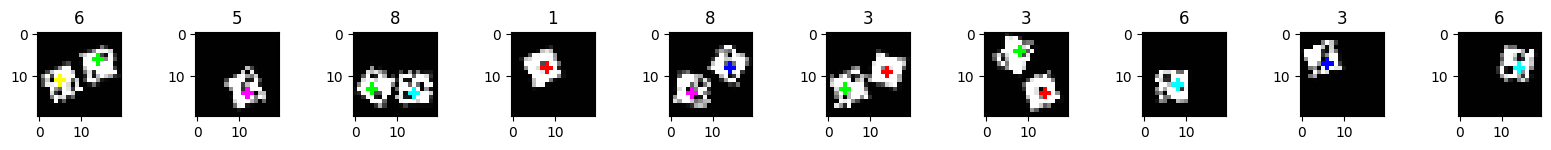

In [9]:
show_center_dataset('data/center_dataset_1st/X_train.npy', 'data/center_dataset_1st/y_train.npy',
                    'data/center_dataset_1st/y_train_center.npy', 'data/center_dataset_1st/y_train_center_target.npy',
                    show_image_count=10)

## P2. 学習 (1回目)

P1 (1回目) で作成したデータセットを用いてサイコロの中心位置と出目を推定するモデルを学習する。

参考実行時間: 1h

In [10]:
!python3 heatmap/train.py exp/0024/sony_dice_net.yaml exp0024 --dst_root outputs/0024/train/convnext_small.in12k_ft_in1k --options module.model.timm_model.model_name=convnext_small.in12k_ft_in1k module.model.timm_model.out_indices=[0,1,2,3]
!python3 heatmap/train.py exp/0024/sony_dice_net.yaml exp0024 --dst_root outputs/0024/train/convnext_tiny.fb_in22k --options module.model.timm_model.model_name=convnext_tiny.fb_in22k module.model.timm_model.out_indices=[0,1,2,3]
!python3 heatmap/train.py exp/0024/sony_dice_net.yaml exp0024 --dst_root outputs/0024/train/tf_efficientnetv2_m --options module.model.timm_model.model_name=tf_efficientnetv2_m module.model.timm_model.out_indices=[1,2,3,4]
!python3 heatmap/train.py exp/0024/sony_dice_net.yaml exp0024 --dst_root outputs/0024/train/tf_efficientnetv2_s --options module.model.timm_model.model_name=tf_efficientnetv2_s module.model.timm_model.out_indices=[1,2,3,4]
!python3 heatmap/train.py exp/0024/sony_dice_net.yaml exp0024 --dst_root outputs/0024/train/tf_efficientnetv2_b2 --options module.model.timm_model.model_name=tf_efficientnetv2_b2 module.model.timm_model.out_indices=[1,2,3,4]

config: exp/0024/sony_dice_net.yaml
experiment: exp0024
dst_root: outputs/0024/train/convnext_small.in12k_ft_in1k
options: ['module.model.timm_model.model_name=convnext_small.in12k_ft_in1k', 'module.model.timm_model.out_indices=[0,1,2,3]']
data:
  dataloader:
    test:
      batch_size: 256
      name: ExampleDataLoader
      num_workers: 4
      pin_memory: true
      shuffle: false
    train:
      batch_size: 256
      collate_stack_columns:
      - image
      - target
      - center_target
      - num_dices_target
      drop_last: true
      name: ExampleDataLoader
      num_workers: 4
      pin_memory: true
      shuffle: true
    validation:
      batch_size: 256
      collate_stack_columns:
      - image
      - target
      - center_target
      - num_dices_target
      name: ExampleDataLoader
      num_workers: 4
      pin_memory: true
      shuffle: false
  dataset:
    test:
      image_npy_path: X_train.npy
      image_size: 40
      name: SonyDiceDataset
      num_classes

## P3. 推論 (1回目)

P2 (1回目)の学習済みモデルを使ってX_train.npyに対して予測を行う。

In [11]:
!python3 heatmap/eval.py outputs/0024/train/convnext_small.in12k_ft_in1k/lightning_logs/version_0/exp0024.yaml outputs/0024/train/convnext_small.in12k_ft_in1k/lightning_logs/version_0/checkpoints/exp0024_latest-v1.ckpt --dst_root outputs/0024/eval/convnext_small.in12k_ft_in1k
!python3 heatmap/eval.py outputs/0024/train/convnext_tiny.fb_in22k/lightning_logs/version_0/exp0024.yaml outputs/0024/train/convnext_tiny.fb_in22k/lightning_logs/version_0/checkpoints/exp0024_latest-v1.ckpt --dst_root outputs/0024/eval/convnext_tiny.fb_in22k
!python3 heatmap/eval.py outputs/0024/train/tf_efficientnetv2_m/lightning_logs/version_0/exp0024.yaml outputs/0024/train/tf_efficientnetv2_m/lightning_logs/version_0/checkpoints/exp0024_latest-v1.ckpt --dst_root outputs/0024/eval/tf_efficientnetv2_m
!python3 heatmap/eval.py outputs/0024/train/tf_efficientnetv2_s/lightning_logs/version_0/exp0024.yaml outputs/0024/train/tf_efficientnetv2_s/lightning_logs/version_0/checkpoints/exp0024_latest-v1.ckpt --dst_root outputs/0024/eval/tf_efficientnetv2_s
!python3 heatmap/eval.py outputs/0024/train/tf_efficientnetv2_b2/lightning_logs/version_0/exp0024.yaml outputs/0024/train/tf_efficientnetv2_b2/lightning_logs/version_0/checkpoints/exp0024_latest-v1.ckpt --dst_root outputs/0024/eval/tf_efficientnetv2_b2

config: outputs/0024/train/convnext_small.in12k_ft_in1k/lightning_logs/version_0/exp0024.yaml
checkpoint: outputs/0024/train/convnext_small.in12k_ft_in1k/lightning_logs/version_0/checkpoints/exp0024_latest-v1.ckpt
target: prediction
dst_root: outputs/0024/eval/convnext_small.in12k_ft_in1k
options: []
data:
  dataloader:
    test:
      batch_size: 256
      name: ExampleDataLoader
      num_workers: 4
      pin_memory: true
      shuffle: false
    train:
      batch_size: 256
      collate_stack_columns:
      - image
      - target
      - center_target
      - num_dices_target
      drop_last: true
      name: ExampleDataLoader
      num_workers: 4
      pin_memory: true
      shuffle: true
    validation:
      batch_size: 256
      collate_stack_columns:
      - image
      - target
      - center_target
      - num_dices_target
      name: ExampleDataLoader
      num_workers: 4
      pin_memory: true
      shuffle: false
  dataset:
    test:
      image_npy_path: X_train.npy
    

## P1. キーポイントデータセット作成 (2回目)

P3 (1回目)の推論結果を活用してサイコロが2つのデータセットにもアノテーションを付ける。また、サイコロ同士を組み合わせてサイコロが3つ映った画像も生成する。

In [12]:
if not Path('data/center_dataset_2nd').exists():
    !python3 tools/create_center_dataset.py {Config.x_train_path} \
                                            {Config.y_train_path} \
                                            data/X_train_num_dices.npy \
                                            data/center_dataset_2nd \
                                            --center_pred_root_list outputs/0024/eval \
                                            --three_dice

アノテーションを自動で作成します
100%|█████████████████████████████████| 200000/200000 [01:44<00:00, 1908.68it/s]
画像同士を組み合わせてサイコロが3つ映った画像を作成中・・・（数十分かかるので気長に待機してください）
100%|█████████████████████████████████████| 99886/99886 [37:02<00:00, 44.95it/s]
save data/center_dataset_2nd/X_train.npy
save data/center_dataset_2nd/y_train.npy
save data/center_dataset_2nd/y_train_center.npy
save data/center_dataset_2nd/y_train_center_target.npy
画像同士を組み合わせてサイコロが2つ映った画像を0枚生成しました
画像同士を組み合わせてサイコロが3つ映った画像を66957枚生成しました
266710件にアノテーションしました


### 可視化

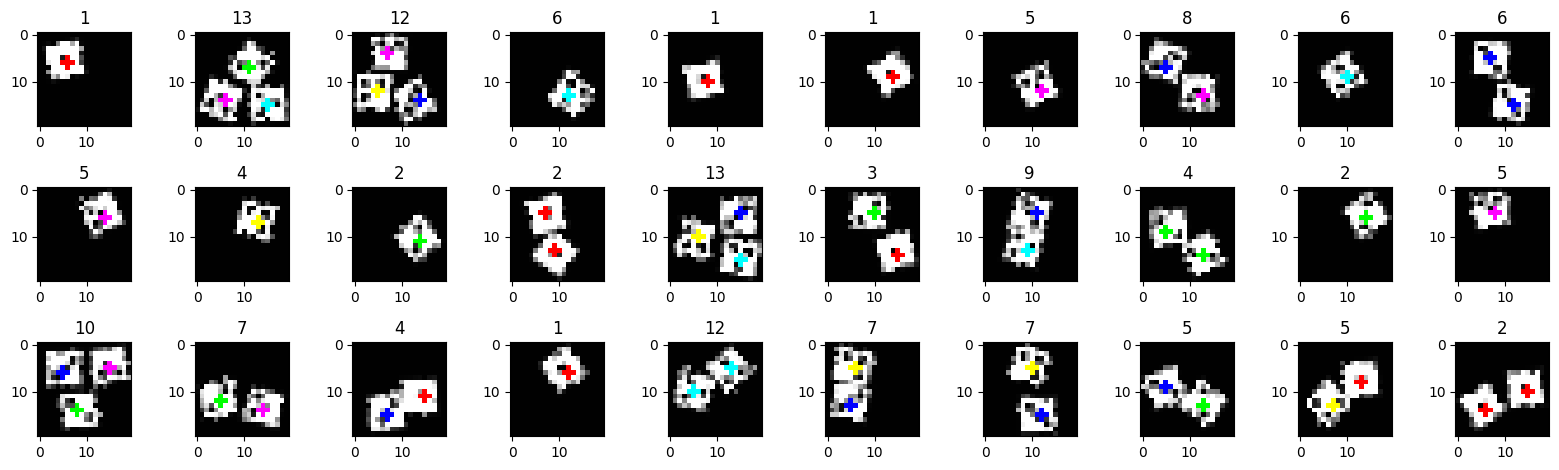

In [13]:
show_center_dataset('data/center_dataset_2nd/X_train.npy', 'data/center_dataset_2nd/y_train.npy',
                    'data/center_dataset_2nd/y_train_center.npy', 'data/center_dataset_2nd/y_train_center_target.npy',
                    show_image_count=30)

## P2. 学習 (2回目)

P1 (2回目)のデータセットを用いてサイコロの中心位置と出目を推定するモデルを学習する。

参考実行時間: 7h

In [14]:
!python3 heatmap/train.py exp/0029/sony_dice_net.yaml exp0029 --dst_root outputs/0029/train/convnext_small.in12k_ft_in1k --options module.model.timm_model.model_name=convnext_small.in12k_ft_in1k module.model.timm_model.out_indices=[0,1,2,3]
!python3 heatmap/train.py exp/0029/sony_dice_net.yaml exp0029 --dst_root outputs/0029/train/convnext_tiny.fb_in22k --options module.model.timm_model.model_name=convnext_tiny.fb_in22k module.model.timm_model.out_indices=[0,1,2,3]
!python3 heatmap/train.py exp/0029/sony_dice_net.yaml exp0029 --dst_root outputs/0029/train/tf_efficientnetv2_m --options module.model.timm_model.model_name=tf_efficientnetv2_m module.model.timm_model.out_indices=[1,2,3,4]
!python3 heatmap/train.py exp/0029/sony_dice_net.yaml exp0029 --dst_root outputs/0029/train/tf_efficientnetv2_s --options module.model.timm_model.model_name=tf_efficientnetv2_s module.model.timm_model.out_indices=[1,2,3,4]
!python3 heatmap/train.py exp/0029/sony_dice_net.yaml exp0029 --dst_root outputs/0029/train/tf_efficientnetv2_b2 --options module.model.timm_model.model_name=tf_efficientnetv2_b2 module.model.timm_model.out_indices=[1,2,3,4]
!python3 heatmap/train.py exp/0037/sony_dice_net.yaml exp0037 --dst_root outputs/0037/train/convnext_small.in12k_ft_in1k --options module.model.timm_model.model_name=convnext_small.in12k_ft_in1k module.model.timm_model.out_indices=[0,1,2,3]
!python3 heatmap/train.py exp/0037/sony_dice_net.yaml exp0037 --dst_root outputs/0037/train/convnext_tiny.fb_in22k --options module.model.timm_model.model_name=convnext_tiny.fb_in22k module.model.timm_model.out_indices=[0,1,2,3]
!python3 heatmap/train.py exp/0037/sony_dice_net.yaml exp0037 --dst_root outputs/0037/train/tf_efficientnetv2_m --options module.model.timm_model.model_name=tf_efficientnetv2_m module.model.timm_model.out_indices=[1,2,3,4]
!python3 heatmap/train.py exp/0037/sony_dice_net.yaml exp0037 --dst_root outputs/0037/train/tf_efficientnetv2_s --options module.model.timm_model.model_name=tf_efficientnetv2_s module.model.timm_model.out_indices=[1,2,3,4]
!python3 heatmap/train.py exp/0037/sony_dice_net.yaml exp0037 --dst_root outputs/0037/train/tf_efficientnetv2_b2 --options module.model.timm_model.model_name=tf_efficientnetv2_b2 module.model.timm_model.out_indices=[1,2,3,4]

config: exp/0029/sony_dice_net.yaml
experiment: exp0029
dst_root: outputs/0029/train/convnext_small.in12k_ft_in1k
options: ['module.model.timm_model.model_name=convnext_small.in12k_ft_in1k', 'module.model.timm_model.out_indices=[0,1,2,3]']
data:
  dataloader:
    test:
      batch_size: 256
      name: ExampleDataLoader
      num_workers: 4
      pin_memory: true
      shuffle: false
    train:
      batch_size: 256
      collate_stack_columns:
      - image
      - target
      - center_target
      - num_dices_target
      drop_last: true
      name: ExampleDataLoader
      num_workers: 4
      pin_memory: true
      shuffle: true
    validation:
      batch_size: 256
      collate_stack_columns:
      - image
      - target
      - center_target
      - num_dices_target
      name: ExampleDataLoader
      num_workers: 4
      pin_memory: true
      shuffle: false
  dataset:
    test:
      image_npy_path: X_train.npy
      image_size: 40
      name: SonyDiceDataset
      num_classes

## P3. 推論 (2回目)

P2 (2回目)の学習済みモデルを使ってX_train.npyに対して予測を行う。

In [15]:
!python3 heatmap/eval.py outputs/0029/train/convnext_small.in12k_ft_in1k/lightning_logs/version_0/exp0029.yaml outputs/0029/train/convnext_small.in12k_ft_in1k/lightning_logs/version_0/checkpoints/exp0029_latest-v1.ckpt --dst_root outputs/0029/eval/convnext_small.in12k_ft_in1k
!python3 heatmap/eval.py outputs/0029/train/convnext_tiny.fb_in22k/lightning_logs/version_0/exp0029.yaml outputs/0029/train/convnext_tiny.fb_in22k/lightning_logs/version_0/checkpoints/exp0029_latest-v1.ckpt --dst_root outputs/0029/eval/convnext_tiny.fb_in22k
!python3 heatmap/eval.py outputs/0029/train/tf_efficientnetv2_m/lightning_logs/version_0/exp0029.yaml outputs/0029/train/tf_efficientnetv2_m/lightning_logs/version_0/checkpoints/exp0029_latest-v1.ckpt --dst_root outputs/0029/eval/tf_efficientnetv2_m
!python3 heatmap/eval.py outputs/0029/train/tf_efficientnetv2_s/lightning_logs/version_0/exp0029.yaml outputs/0029/train/tf_efficientnetv2_s/lightning_logs/version_0/checkpoints/exp0029_latest-v1.ckpt --dst_root outputs/0029/eval/tf_efficientnetv2_s
!python3 heatmap/eval.py outputs/0029/train/tf_efficientnetv2_b2/lightning_logs/version_0/exp0029.yaml outputs/0029/train/tf_efficientnetv2_b2/lightning_logs/version_0/checkpoints/exp0029_latest-v1.ckpt --dst_root outputs/0029/eval/tf_efficientnetv2_b2
!python3 heatmap/eval.py outputs/0037/train/convnext_small.in12k_ft_in1k/lightning_logs/version_0/exp0037.yaml outputs/0037/train/convnext_small.in12k_ft_in1k/lightning_logs/version_0/checkpoints/exp0037_latest-v1.ckpt --dst_root outputs/0037/eval/convnext_small.in12k_ft_in1k
!python3 heatmap/eval.py outputs/0037/train/convnext_tiny.fb_in22k/lightning_logs/version_0/exp0037.yaml outputs/0037/train/convnext_tiny.fb_in22k/lightning_logs/version_0/checkpoints/exp0037_latest-v1.ckpt --dst_root outputs/0037/eval/convnext_tiny.fb_in22k
!python3 heatmap/eval.py outputs/0037/train/tf_efficientnetv2_m/lightning_logs/version_0/exp0037.yaml outputs/0037/train/tf_efficientnetv2_m/lightning_logs/version_0/checkpoints/exp0037_latest-v1.ckpt --dst_root outputs/0037/eval/tf_efficientnetv2_m
!python3 heatmap/eval.py outputs/0037/train/tf_efficientnetv2_s/lightning_logs/version_0/exp0037.yaml outputs/0037/train/tf_efficientnetv2_s/lightning_logs/version_0/checkpoints/exp0037_latest-v1.ckpt --dst_root outputs/0037/eval/tf_efficientnetv2_s
!python3 heatmap/eval.py outputs/0037/train/tf_efficientnetv2_b2/lightning_logs/version_0/exp0037.yaml outputs/0037/train/tf_efficientnetv2_b2/lightning_logs/version_0/checkpoints/exp0037_latest-v1.ckpt --dst_root outputs/0037/eval/tf_efficientnetv2_b2

config: outputs/0029/train/convnext_small.in12k_ft_in1k/lightning_logs/version_0/exp0029.yaml
checkpoint: outputs/0029/train/convnext_small.in12k_ft_in1k/lightning_logs/version_0/checkpoints/exp0029_latest-v1.ckpt
target: prediction
dst_root: outputs/0029/eval/convnext_small.in12k_ft_in1k
options: []
data:
  dataloader:
    test:
      batch_size: 256
      name: ExampleDataLoader
      num_workers: 4
      pin_memory: true
      shuffle: false
    train:
      batch_size: 256
      collate_stack_columns:
      - image
      - target
      - center_target
      - num_dices_target
      drop_last: true
      name: ExampleDataLoader
      num_workers: 4
      pin_memory: true
      shuffle: true
    validation:
      batch_size: 256
      collate_stack_columns:
      - image
      - target
      - center_target
      - num_dices_target
      name: ExampleDataLoader
      num_workers: 4
      pin_memory: true
      shuffle: false
  dataset:
    test:
      image_npy_path: X_train.npy
    

## P1. キーポイントデータセット作成 (3回目)

2回目時点で500枚程度の画像（毎回変化する）に対してアノテーションができていない。対策としてP2 (2回目)の推論結果を活用して再度データセットを構築する。構築方法は2回目と同じ。

（参考までにP2 (2回目)の推論結果をSubmitするとLB 0.9915373）

In [16]:
if not Path('data/center_dataset_3rd').exists():
    !python3 tools/create_center_dataset.py {Config.x_train_path} \
                                            {Config.y_train_path} \
                                            data/X_train_num_dices.npy \
                                            data/center_dataset_3rd \
                                            --center_pred_root_list outputs/0029/eval outputs/0037/eval \
                                            --three_dice

アノテーションを自動で作成します
100%|█████████████████████████████████| 200000/200000 [01:49<00:00, 1825.61it/s]
画像同士を組み合わせてサイコロが3つ映った画像を作成中・・・（数十分かかるので気長に待機してください）
100%|███████████████████████████████████| 100112/100112 [37:01<00:00, 45.07it/s]
save data/center_dataset_3rd/X_train.npy
save data/center_dataset_3rd/y_train.npy
save data/center_dataset_3rd/y_train_center.npy
save data/center_dataset_3rd/y_train_center_target.npy
画像同士を組み合わせてサイコロが2つ映った画像を0枚生成しました
画像同士を組み合わせてサイコロが3つ映った画像を66997枚生成しました
266995件にアノテーションしました


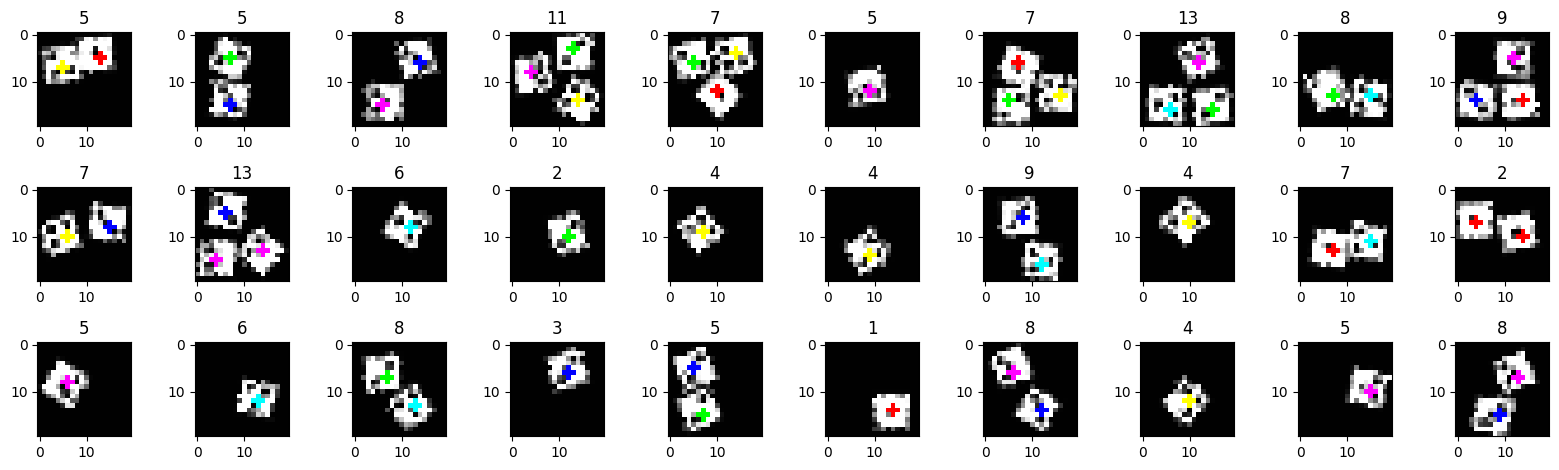

In [17]:
show_center_dataset('data/center_dataset_3rd/X_train.npy', 'data/center_dataset_3rd/y_train.npy',
                    'data/center_dataset_3rd/y_train_center.npy', 'data/center_dataset_3rd/y_train_center_target.npy',
                    show_image_count=30)

## P4. 学習

テストデータのサイコロの位置を特定するために、6のデータセットを用いてサイコロの中心位置のみを推定するモデルを学習する。（出目は推定しないので6クラスではなく1クラス。）

参考実行時間: 3.5h

In [18]:
# 6で作成したデータセットのクラスラベルを6種→1種に変換したものを作成する
y_train_center_target = np.load('data/center_dataset_3rd/y_train_center_target.npy')
y_train_center_target[y_train_center_target != 255] = 1
np.save('data/center_dataset_3rd/y_train_center_target_1class', y_train_center_target)

In [19]:
!python3 heatmap/train.py exp/0044/sony_dice_net.yaml exp0044 --dst_root outputs/0044/train/convnext_small.in12k_ft_in1k --options module.model.timm_model.model_name=convnext_small.in12k_ft_in1k module.model.timm_model.out_indices=[0,1,2,3]
!python3 heatmap/train.py exp/0044/sony_dice_net.yaml exp0044 --dst_root outputs/0044/train/convnext_tiny.fb_in22k --options module.model.timm_model.model_name=convnext_tiny.fb_in22k module.model.timm_model.out_indices=[0,1,2,3]
!python3 heatmap/train.py exp/0044/sony_dice_net.yaml exp0044 --dst_root outputs/0044/train/tf_efficientnetv2_m --options module.model.timm_model.model_name=tf_efficientnetv2_m module.model.timm_model.out_indices=[1,2,3,4]
!python3 heatmap/train.py exp/0044/sony_dice_net.yaml exp0044 --dst_root outputs/0044/train/tf_efficientnetv2_s --options module.model.timm_model.model_name=tf_efficientnetv2_s module.model.timm_model.out_indices=[1,2,3,4]
!python3 heatmap/train.py exp/0044/sony_dice_net.yaml exp0044 --dst_root outputs/0044/train/tf_efficientnetv2_b2 --options module.model.timm_model.model_name=tf_efficientnetv2_b2 module.model.timm_model.out_indices=[1,2,3,4]

config: exp/0044/sony_dice_net.yaml
experiment: exp0044
dst_root: outputs/0044/train/convnext_small.in12k_ft_in1k
options: ['module.model.timm_model.model_name=convnext_small.in12k_ft_in1k', 'module.model.timm_model.out_indices=[0,1,2,3]']
data:
  dataloader:
    test:
      batch_size: 256
      name: ExampleDataLoader
      num_workers: 4
      pin_memory: true
      shuffle: false
    train:
      batch_size: 256
      collate_stack_columns:
      - image
      - target
      - center_target
      - num_dices_target
      drop_last: true
      name: ExampleDataLoader
      num_workers: 4
      pin_memory: true
      shuffle: true
    validation:
      batch_size: 256
      collate_stack_columns:
      - image
      - target
      - center_target
      - num_dices_target
      name: ExampleDataLoader
      num_workers: 4
      pin_memory: true
      shuffle: false
  dataset:
    test:
      image_npy_path: X_test.npy
      image_size: 40
      name: SonyDiceDataset
      num_classes:

## P5. 推論

P4の学習済みモデルを使ってX_test.npyに対して予測を行う。

In [20]:
!python3 heatmap/eval.py outputs/0044/train/convnext_small.in12k_ft_in1k/lightning_logs/version_0/exp0044.yaml outputs/0044/train/convnext_small.in12k_ft_in1k/lightning_logs/version_0/checkpoints/exp0044_latest-v1.ckpt --dst_root outputs/0044/eval/convnext_small.in12k_ft_in1k
!python3 heatmap/eval.py outputs/0044/train/convnext_tiny.fb_in22k/lightning_logs/version_0/exp0044.yaml outputs/0044/train/convnext_tiny.fb_in22k/lightning_logs/version_0/checkpoints/exp0044_latest-v1.ckpt --dst_root outputs/0044/eval/convnext_tiny.fb_in22k
!python3 heatmap/eval.py outputs/0044/train/tf_efficientnetv2_m/lightning_logs/version_0/exp0044.yaml outputs/0044/train/tf_efficientnetv2_m/lightning_logs/version_0/checkpoints/exp0044_latest-v1.ckpt --dst_root outputs/0044/eval/tf_efficientnetv2_m
!python3 heatmap/eval.py outputs/0044/train/tf_efficientnetv2_s/lightning_logs/version_0/exp0044.yaml outputs/0044/train/tf_efficientnetv2_s/lightning_logs/version_0/checkpoints/exp0044_latest-v1.ckpt --dst_root outputs/0044/eval/tf_efficientnetv2_s
!python3 heatmap/eval.py outputs/0044/train/tf_efficientnetv2_b2/lightning_logs/version_0/exp0044.yaml outputs/0044/train/tf_efficientnetv2_b2/lightning_logs/version_0/checkpoints/exp0044_latest-v1.ckpt --dst_root outputs/0044/eval/tf_efficientnetv2_b2

config: outputs/0044/train/convnext_small.in12k_ft_in1k/lightning_logs/version_0/exp0044.yaml
checkpoint: outputs/0044/train/convnext_small.in12k_ft_in1k/lightning_logs/version_0/checkpoints/exp0044_latest-v1.ckpt
target: prediction
dst_root: outputs/0044/eval/convnext_small.in12k_ft_in1k
options: []
data:
  dataloader:
    test:
      batch_size: 256
      name: ExampleDataLoader
      num_workers: 4
      pin_memory: true
      shuffle: false
    train:
      batch_size: 256
      collate_stack_columns:
      - image
      - target
      - center_target
      - num_dices_target
      drop_last: true
      name: ExampleDataLoader
      num_workers: 4
      pin_memory: true
      shuffle: true
    validation:
      batch_size: 256
      collate_stack_columns:
      - image
      - target
      - center_target
      - num_dices_target
      name: ExampleDataLoader
      num_workers: 4
      pin_memory: true
      shuffle: false
  dataset:
    test:
      image_npy_path: X_test.npy
     

## P6. クラス分類データセット作成

画像からサイコロ部分だけを切り出したデータセットを作成する。

In [21]:
if not Path('data/classification_dataset').exists():
    !python3 tools/create_classification_dataset.py data/center_dataset_3rd/X_train.npy \
                                                    data/center_dataset_3rd/y_train_center.npy \
                                                    data/center_dataset_3rd/y_train_center_target.npy \
                                                    X_test.npy \
                                                    data/classification_dataset \
                                                    --center_pred_root_list outputs/0044/eval

データセットを自動で作成します
100%|███████████████████████████████████| 24922/24922 [00:05<00:00, 4311.90it/s]


### 可視化

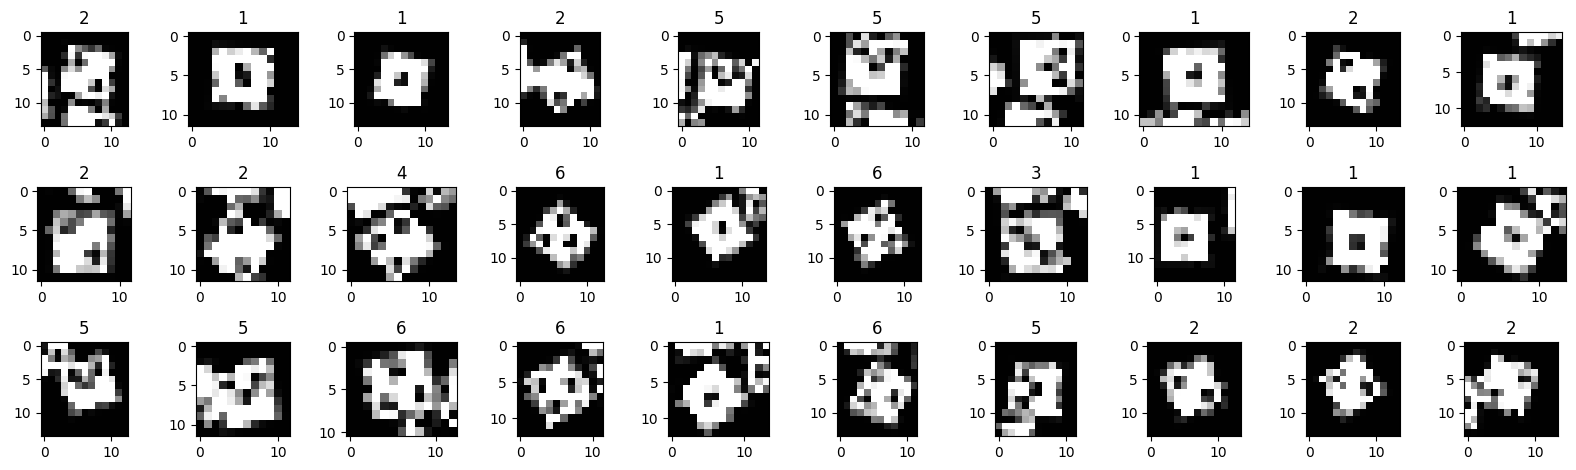

In [22]:
image_paths = random.sample(list(Path('data/classification_dataset/train').glob('**/*.png')), 30)
images = [cv2.imread(p.as_posix()) for p in image_paths]
targets = [str(int(p.parts[-2]) + 1) for p in image_paths]
show_images(images, titles=targets)

## P7. 学習

P6で作成したデータセットを使ってクラス分類モデルを学習する。原因不明だがconvnext_smallの重みが学習過程で壊れることがあった。調査に時間をかけられないので暫定的にシードを変えることで回避した。

In [23]:
!python3 multiclass_classification/train.py exp/0055/sony_dice_net.yaml exp0055 --dst_root outputs/0055/train/convnext_base_in22ft1k --options module.model.timm_model.model_name=convnext_base_in22ft1k
!python3 multiclass_classification/train.py exp/0055/sony_dice_net.yaml exp0055 --dst_root outputs/0055/train/convnext_small.in12k_ft_in1k --options module.model.timm_model.model_name=convnext_small.in12k_ft_in1k seed=2024
!python3 multiclass_classification/train.py exp/0055/sony_dice_net.yaml exp0055 --dst_root outputs/0055/train/convnext_tiny.fb_in22k --options module.model.timm_model.model_name=convnext_tiny.fb_in22k
!python3 multiclass_classification/train.py exp/0055/sony_dice_net.yaml exp0055 --dst_root outputs/0055/train/tf_efficientnetv2_m --options module.model.timm_model.model_name=tf_efficientnetv2_m
!python3 multiclass_classification/train.py exp/0055/sony_dice_net.yaml exp0055 --dst_root outputs/0055/train/tf_efficientnetv2_s --options module.model.timm_model.model_name=tf_efficientnetv2_s

config: exp/0055/sony_dice_net.yaml
experiment: exp0055
dst_root: outputs/0055/train/convnext_base_in22ft1k
options: ['module.model.timm_model.model_name=convnext_base_in22ft1k']
data:
  dataloader:
    test:
      batch_size: 256
      name: ExampleDataLoader
      num_workers: 4
      pin_memory: true
      shuffle: false
    train:
      batch_size: 256
      collate_stack_columns:
      - image
      - target
      drop_last: true
      name: ExampleDataLoader
      num_workers: 4
      pin_memory: true
      shuffle: true
    validation:
      batch_size: 256
      collate_stack_columns:
      - image
      - target
      name: ExampleDataLoader
      num_workers: 4
      pin_memory: true
      shuffle: false
  dataset:
    test:
      image_dir: data/classification_dataset/test
      image_size: 42
      name: SonyDiceDataset
      num_classes: 6
      transform:
        name: SonyDiceTransform
        resize_cfg:
          height: 42
          interpolation: 0
          p: 1.0
 

## P8. 推論

P7の学習済みモデルを使ってX_testのサイコロ部分を切り出したデータセットに対してサイコロの予測を行う。

In [24]:
# 8で作成したテストデータのサイコロ部分をクロップしたデータに対して推論する
!python3 multiclass_classification/eval.py outputs/0055/train/convnext_base_in22ft1k/lightning_logs/version_0/exp0055.yaml outputs/0055/train/convnext_base_in22ft1k/lightning_logs/version_0/checkpoints/exp0055_latest-v1.ckpt --dst_root outputs/0055/eval/convnext_base_in22ft1k
!python3 multiclass_classification/eval.py outputs/0055/train/convnext_small.in12k_ft_in1k/lightning_logs/version_0/exp0055.yaml outputs/0055/train/convnext_small.in12k_ft_in1k/lightning_logs/version_0/checkpoints/exp0055_latest-v1.ckpt --dst_root outputs/0055/eval/convnext_small.in12k_ft_in1k
!python3 multiclass_classification/eval.py outputs/0055/train/convnext_tiny.fb_in22k/lightning_logs/version_0/exp0055.yaml outputs/0055/train/convnext_tiny.fb_in22k/lightning_logs/version_0/checkpoints/exp0055_latest-v1.ckpt --dst_root outputs/0055/eval/convnext_tiny.fb_in22k
!python3 multiclass_classification/eval.py outputs/0055/train/tf_efficientnetv2_m/lightning_logs/version_0/exp0055.yaml outputs/0055/train/tf_efficientnetv2_m/lightning_logs/version_0/checkpoints/exp0055_latest-v1.ckpt --dst_root outputs/0055/eval/tf_efficientnetv2_m
!python3 multiclass_classification/eval.py outputs/0055/train/tf_efficientnetv2_s/lightning_logs/version_0/exp0055.yaml outputs/0055/train/tf_efficientnetv2_s/lightning_logs/version_0/checkpoints/exp0055_latest-v1.ckpt --dst_root outputs/0055/eval/tf_efficientnetv2_s

config: outputs/0055/train/convnext_base_in22ft1k/lightning_logs/version_0/exp0055.yaml
checkpoint: outputs/0055/train/convnext_base_in22ft1k/lightning_logs/version_0/checkpoints/exp0055_latest-v1.ckpt
score_th: 0.25
target: prediction
dst_root: outputs/0055/eval/convnext_base_in22ft1k
options: []
data:
  dataloader:
    test:
      batch_size: 256
      name: ExampleDataLoader
      num_workers: 4
      pin_memory: true
      shuffle: false
    train:
      batch_size: 256
      collate_stack_columns:
      - image
      - target
      drop_last: true
      name: ExampleDataLoader
      num_workers: 4
      pin_memory: true
      shuffle: true
    validation:
      batch_size: 256
      collate_stack_columns:
      - image
      - target
      name: ExampleDataLoader
      num_workers: 4
      pin_memory: true
      shuffle: false
  dataset:
    test:
      image_dir: data/classification_dataset/test
      image_size: 42
      name: SonyDiceDataset
      num_classes: 6
      transform

## P9. アンサンブル

P8の5つの推論結果から多数決を取って最終的な予測値を作成する。

In [25]:
# クラス分類モデルの出力結果を取得
prediction_result_files = sorted(Path(f'outputs/0055/eval').glob('**/*_preds.csv'))

# 5モデルの予測結果から多数決を取り最終結果とする
predictions_dict = dict()
for prediction_result_file in prediction_result_files:
    df = pd.read_csv(prediction_result_file)
    model = prediction_result_file.parts[-4]
    predictions_dict[model] = df['pred']
pred_df = pd.DataFrame(data=predictions_dict)
max_frequency = pred_df.apply(lambda row: Counter(row).most_common(1)[0][1], axis=1)
pred = pred_df.apply(lambda row: Counter(row).most_common(1)[0][0], axis=1).to_numpy()
pred_df['max_frequency'] = max_frequency
pred_df['pred'] = pred
for i in range(1, len(prediction_result_files)+1):
    print(f"重複数{i}: {np.sum(pred_df['max_frequency'] == i)}件 ({(np.sum(pred_df['max_frequency'] == i) / 24922 * 100):.2f}%)")

# submit.csvを作成する
submit_df = pd.DataFrame(data=dict(
    index=list(range(len(pred_df.pred))),
    pred=pred_df.pred.to_numpy(),
))
submit_df.to_csv(f'submit.csv', header=False, index=False)

重複数1: 0件 (0.00%)
重複数2: 14件 (0.06%)
重複数3: 98件 (0.39%)
重複数4: 103件 (0.41%)
重複数5: 24707件 (99.14%)
